# 匯入一些套件還有匯入文檔

In [1]:
%pylab inline
import time
import re
import matplotlib.pyplot as plt
import pandas as pd
import string
import codecs
import os
import jieba
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from sklearn import naive_bayes as bayes
from sklearn.model_selection import train_test_split
#簡轉繁
from hanziconv import HanziConv

#ham與spam的每封郵件list
ham_text = []
spam_text = []
#ham與spam的數據集
ham_data = []
spam_data = []
#取得目前工作目錄
SaveDirectory = os.getcwd() 
#獲得文檔列表
listham = os.listdir(SaveDirectory+'\\data\\normal')
listspam = os.listdir(SaveDirectory+'\\data\\spam')
#數據集數量

print('spam total：',len(listspam))
print('ham total：',len(listham))


Populating the interactive namespace from numpy and matplotlib
spam total： 7775
ham total： 7063


# 先匯入HAM文檔並給予label = 0

In [2]:
for fileName in listham:
        with open('data/normal/'+fileName, 'r',encoding='gbk') as f:
            #文本每一列儲存
            text=[]
            # 過濾非中文字符，正規化
            for line in f.readlines():
                pattern = re.compile('[^\u4e00-\u9fa5]') #正規化(去除非中文字符)
                line = pattern.sub("", line) #將其他字符取代為""
                content = line.strip().split() #去除一些空白.換行
                text = text+content #儲存這個文本的內容
            text = " ".join(text) #將文本內容list加入全部文本的list
            ham_text.append(HanziConv.toTraditional(text)) #簡轉繁
ham_data = pd.DataFrame(ham_text,columns=['text']) #將list改成dataframe
ham_data['label']='0' #將資料類別加上 0:ham 1:spam
ham_data.head()


,text,label
0,這事兒還有續集 因為我姐她們買房子後來裝修的時候沒錢她婆婆他們就贊助瞭萬塊 這下一吵她婆婆就...,0
1,越發覺得這個姐夫不錯瞭 那萬還是趕緊還瞭吧 標題姐姐快要生孩子瞭很感慨 發信站水木社區站內 ...,0
2,或許某些農村吧 在一個當性彆勞動力富裕程度的地方還是可以理解的 標題姐姐快要生孩子瞭很感慨 ...,0
3,最近經常看到你說一些很武斷的話 所謂保胎確實是要躺在床上不能動的尤其是先兆流産有齣血的時候 ...,0
4,他們分手是說性格不閤 沒多久然後我們交往 還算比較愉快 當初因為他經常和聯係我曾跟他吵過多次...,0


# 先匯入SPAM文檔並給予label = 1

In [3]:
for fileName in listspam:
        with open('data/spam/'+fileName, 'r',encoding='gbk') as f:
            text=[]
            # 过滤掉非中文字符
            for line in f.readlines():
                pattern = re.compile('[^\u4e00-\u9fa5]')
                line = pattern.sub("", line)
                content = line.strip().split()
                text = text+content
            text = " ".join(text)
            spam_text.append(HanziConv.toTraditional(text))
spam_data = pd.DataFrame(spam_text,columns=['text'])
spam_data['label']='1'
spam_data.head()

,text,label
0,會員注冊邀請書 全國最低價域名空間大放送 國際頂級域名注冊驚暴價元年元年連續注冊年以上 國傢...,1
1,你好 以茶會友以茶聯誼喝茶就喝安溪鐵觀音 本廠是專業生産批發各等級鐵觀音茶葉的購買聯係 在綫...,1
2,尊敬的先生小姐 您好 首先感謝您抽時間查看以下信息 我公司一直緻力於研發生産銷售施工環氧樹脂...,1
3,先生 你好 批發麻醉藥催情藥墮胎藥避孕藥飲料型噴霧型香煙型揮發型等各類國際國內製藥企業推齣的...,1
4,貴公司負責人經理財務您好 我是深圳市創偉實業有限公司的我司實力雄厚有著良 好的社會關係也有部...,1


# 把匯入的 SPAM與HAM結合並打亂

In [4]:
all_data = pd.concat([spam_data,ham_data],axis=0, ignore_index=True)  #將ham lsit與spam list串起來
all_data = all_data.sample(frac=1).reset_index(drop=True) #sample frac = 1 是把數據都打亂 resr_index是把index也重設
print('data shape：',all_data.shape)
print('spams in rows：',all_data.loc[all_data['label']=="1"].shape[0])
print('hams in rows：',all_data.loc[all_data['label']=="0"].shape[0])
all_data.head(6)

data shape： (14838, 2)
spams in rows： 7775
hams in rows： 7063


,text,label
0,貴公司負責人經理財務您好 我公司是深圳市如意廣告有限公司我公司實力雄厚 因我公司是定額稅額每...,1
1,,1
2,我在一所很普通的工科大學讀本科現在已經在準備考研的復習尤其對這學期的計算機專業課當然上課講的...,0
3,不錯啦有個期限也好至少知道珍惜 俺的就乾過夢想著地久天長卻短期投機失敗的事 說實話現在感情的...,0
4,尊敬客戶您好 世紀是信息時代企業信息化將使企業在有限的投入中獲得最大程度的收益 我公司專業為...,1
5,有個朋友告訴我每個人的愛就象一杯酒你每次付齣你的愛有多少你杯中的酒就會少多少而再補充進來的就...,0


# 接著載入停詞表及斷詞

In [5]:
#載入 停用詞 (stopwords) 自動過濾掉某些字或詞
stopwords = codecs.open(os.path.join(SaveDirectory+'\data', 'stopwords_tr.txt'), 'r', 'utf-8').read().split('\r\n')
#下面斷詞
processed_texts = []
for text in all_data["text"]:
    words = []
    seg_list = jieba.cut(text) #利用Jieba斷詞
    for seg in seg_list: 
        # isalpha()檢測詞是否由字符組成，且不在停用詞的list中
        if (seg.isalpha()) & (seg not in stopwords):
            words.append(seg)
    sentence = " ".join(words)
    processed_texts.append(sentence)
all_data["text"] = processed_texts #利用過濾且斷好的詞取代文本


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\zxc98\AppData\Local\Temp\jieba.cache
Loading model cost 0.573 seconds.
Prefix dict has been built succesfully.


# 接著將資料切成訓練及與測試集

In [6]:
#traindate & testdata
train_set, test_set, trainlabel, testlabel = train_test_split(all_data["text"], all_data["label"], test_size = 0.15)

In [7]:
print("train:"+str(len(train_set)))
print("test:"+str(len(test_set)))
trainlabel[trainlabel=='1'].shape

train:12612
test:2226


(6621,)

In [8]:
trainlabel_orig = trainlabel.copy()
# 取消一些標記的數據
unlabeled_size = 2597
#loc可以選擇數據(把上面數量的POSTIVE DATA隱藏為UNLABELED DATA)
trainlabel.loc[
    np.random.choice(
        trainlabel[trainlabel == '1'].index, 
        replace = False, 
        size = unlabeled_size
    )
] = '0'
trainlabel[trainlabel=='1'].shape

(4024,)

In [9]:
positive_train = trainlabel[trainlabel=='1'].index
positive_data = train_set[positive_train]
positive_spam = pd.DataFrame(
    {
     'text':positive_data, 
     'label':trainlabel[positive_train],
     'truth':trainlabel_orig[positive_train]
    })
positive_spam.shape


(4024, 3)

In [10]:
import re
def generate_key_list(all_data, size_table=200,ignore=2):
    dict_spam_raw = dict()
    dict_genuine_raw = dict()
    dict_IDF = dict()

    # 去除字母外的所有內容.
    for i in range(all_data.shape[0]):
        finds = all_data.iloc[i].text.split(" ")
        if all_data.iloc[i].label == '1':
            for find in finds:
                if len(find)<ignore: continue
                try:
                    dict_spam_raw[find] = dict_spam_raw[find] + 1
                except:	
                    dict_spam_raw[find] = dict_spam_raw.get(find,1) #若是新的文字因為後面get找不到這個索引會返回逗點後面的值
                    dict_genuine_raw[find] = dict_genuine_raw.get(find,0)
        else:
            for find in finds:
                if len(find)<ignore: continue
                try:
                    dict_genuine_raw[find] = dict_genuine_raw[find] + 1
                except:	
                    dict_genuine_raw[find] = dict_genuine_raw.get(find,1)
                    dict_spam_raw[find] = dict_spam_raw.get(find,0)

        word_set = set()
        for find in finds:
            if not(find in word_set):
                if len(find)<ignore: continue
                try:
                    dict_IDF[find] = dict_IDF[find] + 1
                except:	
                    dict_IDF[find] = dict_IDF.get(find,1)
            word_set.add(find)
    word_df = pd.DataFrame(list(zip(dict_genuine_raw.keys(),dict_genuine_raw.values(),dict_spam_raw.values(),dict_IDF.values())))
    word_df.columns = ['keyword','genuine','spam','IDF']
    word_df['genuine'] = word_df['genuine'].astype('float')/all_data[all_data['label']=='0'].shape[0]
    word_df['spam'] = word_df['spam'].astype('float')/all_data[all_data['label']=='1'].shape[0]
    word_df['IDF'] = np.log10(word_df.shape[0]/word_df['IDF'].astype('float'))
    word_df['genuine_IDF'] = word_df['genuine']*word_df['IDF']
    word_df['spam_IDF'] = word_df['spam']*word_df['IDF']
    word_df['diff']=word_df['spam_IDF']-word_df['genuine_IDF']
    selected_spam_key = word_df.sort_values('diff',ascending=False)  
    keyword_dict = dict()
    i = 0
    for word in selected_spam_key.head(size_table).keyword:
        keyword_dict.update({word.strip():i})
        i+=1
    return keyword_dict   
# build a tabu list based on the training data
size_table = 200               # 多少特徵維度去分類SPAM
word_len_ignored = 2            # 忽略那些比這個還要小的字詞
keyword_dict=generate_key_list(positive_spam, size_table, word_len_ignored)

In [11]:
#排序越前面的代表出現在SPAM的機率越大
for key,value in keyword_dict.items():
    print('{key}:{value}'.format(key = key, value = value))

公司:0
負責人:1
經理:2
財務:3
您好:4
粵豐:5
實業:6
有限公司:7
廣州:8
東莞:9
分公司:10
我司:11
實力:12
雄厚:13
有著:14
良好:15
社會關:16
進項:17
多現:18
完成:19
每月:20
售額度:21
一部分:22
增值:23
稅電腦:24
發票:25
左右:26
普通商品:27
銷售稅:28
國稅:29
地稅:30
優惠代開:31
作點:32
數較:33
低還:34
數量:35
額度:36
大小:37
商討:38
優惠:39
點數:40
鄭重:41
承諾:42
所用:43
真票:44
希望:45
能夠:46
機會:47
貴司:48
如貴司:49
疑慮:50
擔心:51
可上:52
網查證:53
直接:54
稅務局:55
抵扣:56
核對:57
閤作:58
一次:59
永久:60
朋友:61
信息:62
有效:63
如須:64
一步:65
洽商:66
詳情:67
電小時:68
業務:69
郵箱:70
劉漢文:71
順祝:72
商祺:73
尊敬:74
首祝貴:75
生意:76
興隆:77
財源:78
廣進:79
華誠實業:80
外資:81
企業:82
信譽:83
司進:84
餘額:85
外代:86
稅發票:87
稅點:88
普通:89
廣告:90
運輸:91
建築安裝:92
所開:93
網查詢:94
稅務驗證:95
歡迎:96
電詢:97
林先生:98
電話:99
手機:100
冒昧:101
之處:102
敬請:103
願諒:104
領導:105
現有:106
抵帳:107
新叉車:108
裝載機:109
無用:110
現以:111
優惠價格:112
市場:113
半價:114
如貴:115
需要:116
請速:117
北京:118
偉光:119
機械:120
侯經理:121
地址:122
北京市:123
朝陽區:124
化工:125
南路:126
你好:127
源華:128
可代開:129
問謝謝:130
張偉明:131
電子:132
信箱:133
惠源:134
成立:135
全國:136
各大中:137
城市:138
業務範圍:139
廣泛:140
銷售:141
閤理:142
開代:143
開範圍:144
商品:145
服務租賃:146
建築安裝餐:147
定額:148
最高:149
點及:150
海關:151

In [12]:
unlabeled_train = trainlabel[trainlabel=='0'].index
unlabeled_data = train_set[unlabeled_train]
unlabeled_df = pd.DataFrame(
    {
        'text':unlabeled_data, 
        'label':trainlabel[unlabeled_train],
        'truth':trainlabel_orig[unlabeled_train]
    })
unlabeled_df.head()

,label,text,truth
10370,0,大哥 原來 男朋友 北京 倒車 女朋友 幫買 車票 鍾 車到 瞭 北京 點多 車離京 女朋友...,0
5999,0,您好 德諾特 實業 有限公司 公司 現有 額外 發票 代開 詳情 公司 現有 額外 發票 增...,1
10358,0,以下 文字 轉載 自討論區 發信 人 吆喝 信區 標題 今天 看電視 說 一個 一個 人 隻...,0
8428,0,收到 過花 冰箱 裏 估計現 扔 瞭 今天 晚上 點多 纍 瞭 一整天 踉踉 蹌蹌 迴 傢 ...,0
5235,0,尊敬 女士 先生 您好 請 原諒 方式 給您帶 實惠 長 途電話 卡特 價郵票 優惠 好消息...,1


In [13]:
all_data = pd.concat([positive_spam,unlabeled_df],axis=0, ignore_index=False)  #將ham lsit與spam list串起來
all_data = all_data.sample(frac=1) #sample frac = 1 是把數據都打亂
all_data.head(10)


,label,text,truth
8287,0,分特 你老 媽啊 一定 先 糊嚕 走 用什麼 手段 長 痛 短痛 孩子 生完 瞭 再 接 迴...,0
10570,0,尊敬 先生 小姐 您好 感謝 抽 時間 查看 以下 信息 公司 一直 緻 力 研 發 生 産...,1
5353,1,公司 財務 經理 您好 富華 實業 有限公司 年 月經 工商局 注冊 成立 集 生 産 銷售...,1
7338,0,尊敬 公司 經理 財務部 你好 廣 州市 盛華 實業 有限公司 公司 普通商品 銷售 發票 ...,1
6308,0,知道 分析 原因 似乎 討厭 繁文 縟 節的 人 我覺 婚禮 要求 親戚 請 吃 一頓 飯 ...,0
14666,0,感謝 開本 郵件 祝您 工作 順利 生意 興隆 這是 一封 善意 郵件 造成 不便 敬請 原...,1
4616,1,公司 負責人 經理 財務 您好 達明 實業 有限公司 廣州 東莞 市 分公司 我司 實力 雄...,1
7157,0,說 小喜 歡變 形金剛 時要 二十 塊 錢 一個 算是 很貴 東西 瞭 一直 昨天 天津 玩...,0
5824,0,颱 灣 公司 傢 不錯 公司 薪水 待遇 不錯 麵 試 兩周 後 迴 復 瞭 一個 問題 原...,0
12372,1,使用 郵件 主題給 寫信 第一 網站 確實 好 全免 費網 站 感覺 好 請 記住 網址 一...,1


In [14]:
# all_data.loc[positive_train[:]]
all_data['truth'] = trainlabel_orig
all_data['label'][all_data['label']=="1"].shape

(4024,)

In [15]:
 all_data['label'][all_data['label'] == '1'].shape

(4024,)

In [517]:
unlabeled_size = 3200
sp_index=[]
sp_index = all_data['label'].loc[
    np.random.choice(
        all_data['label'][all_data['label'] == '1'].index, 
        replace = False, 
        size = unlabeled_size
    )
].index
sp_index
# all_data.loc[positive_train[:]]

Int64Index([12927, 14426,  4492, 14064,  2595,  8697,  1612, 13244, 13715,
            14615,
            ...
             3263,  3975, 14051,  1211, 10869,  6954,  9920,  8039,  3806,
             4587],
           dtype='int64', length=3200)

In [518]:
all_data['label'].loc[sp_index[:]] = 0 #SP
all_data['label'].loc[sp_index[:]].shape


(3200,)

# -------------------------------SP  上面

In [519]:
def convert_Content(text, keyword_dict):
    #判斷是否有此特徵
    m = len(keyword_dict) #維度數量
    res = np.int_(np.zeros(m)) #建置一個幾維度的向量
    finds = text.split(" ") #將文本內容切割(類似中文斷詞)
    for find in finds:
        try:
            #若比對完有此特徵則特徵改為1
            i = keyword_dict[find] 
            res[i]=1
        except:
            continue
    return res
def raw2feature(all_data,keyword_dict):
    n_all_data = all_data.shape[0]
    m = len(keyword_dict)
    X_all_data = np.zeros((n_all_data,m));
    Y_all_data = np.int_(all_data.label=='1')
    for i in range(n_all_data):
        X_all_data[i,:] = convert_Content(all_data.iloc[i].text, keyword_dict)
    return [X_all_data,Y_all_data]
     
all_data_matrix=raw2feature(all_data,keyword_dict)

In [520]:
# positive_train  正樣本的index
# unlabeled_train 未標記樣本的index
# all_train 混合完的index
all_data_matrix[1][all_data_matrix[1]==1].shape

(424,)

# 使用NB計算他們的機率

In [521]:
# 使用一般的算法
from sklearn.naive_bayes import GaussianNB
model_NB = GaussianNB(priors=None)
model_NB.fit(all_data_matrix[0], all_data_matrix[1])
# 儲存次方法給定的分數
results = pd.DataFrame({
    'truth'      : all_data['truth'],   # 真實標籤
    'label'      : all_data['label'],        # 預測標籤
    'output_std' : model_NB.predict_proba(all_data_matrix[0])[:,0],   # 隨機森林分數(求屬於標籤1的概率)
}, columns = ['truth', 'label', 'output_std'])
# print(results)

In [522]:
results.loc[sp_index[:]].head()


,truth,label,output_std
12927,1,0,3.123374e-17
14426,1,0,1.368813e-44
4492,1,0,1.817768e-15
14064,1,0,5.445859e-39
2595,1,0,4.096991e-29


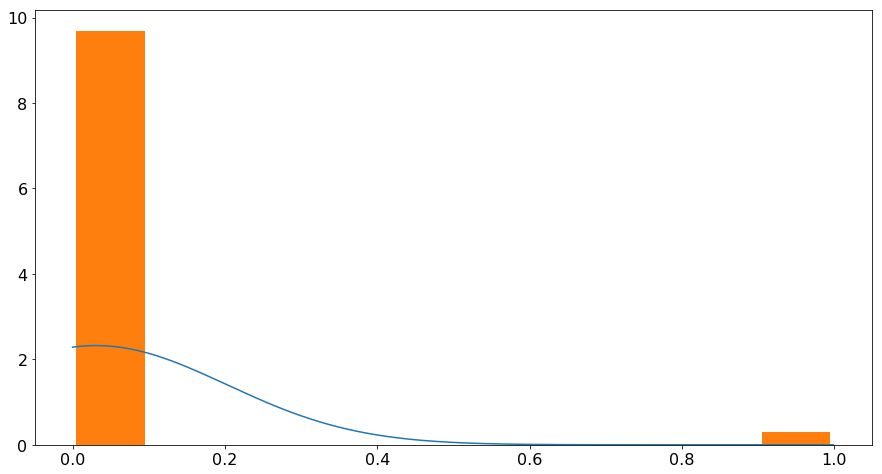

(3102,)


In [523]:
from scipy import stats
sp_data = results['output_std'].loc[sp_index[:]]
sp_counts = len(results['output_std'].loc[sp_index[:]])
sp_mean = results['output_std'].loc[sp_index[:]].mean()
sp_std = results['output_std'].loc[sp_index[:]].std()
# 绘制概率密度分布图
x = np.arange(0, 1, 0.001)
# PDF是概率密度函数
y = stats.norm.pdf(x, loc=sp_mean, scale=sp_std)
plt.plot(x, y)
plt.hist(sp_data, bins=10, rwidth=0.9, normed=True)
plt.show()
print(results['output_std'].loc[sp_index[:]][results['output_std']<0.5].shape)

In [524]:
from scipy import stats
ci = 0.68
for i in range(11):
    conf_intveral = stats.norm.interval(ci, loc=sp_mean, scale=sp_std) #數字為信賴區間
    ci += 0.02
    print(conf_intveral)
    t=[]
    t = sp_data[sp_data<conf_intveral[1]]
    t = t[t>conf_intveral[0]]
    RN = results
    RN = RN[(~RN.index.isin(sp_index))] #去除U中的SP
    RN_index = RN['output_std'][RN['output_std']>=max(t)].index
    print(1-np.int_(RN['truth'].loc[RN_index[:]]).mean())
    
    
# 函数曲线下68.268949%的面积在平均数左右的一个标准差范围内

# 函数曲线下95.449974%的面积在平均数左右两个标准差的范围内

# 函数曲线下99.730020%的面积在平均数左右三个标准差的范围内

# 函数曲线下99.993666%的面积在平均数左右四个标准差的范围内

(-0.14030029453422507, 0.20132222612876732)
0.8528225806451613
(-0.14751014147946434, 0.20853207307400654)
0.8528225806451613
(-0.1550481325624251, 0.2160700641569673)
0.8528225806451613
(-0.16296156996898523, 0.22398350156352753)
0.8528225806451613
(-0.1713085161679981, 0.23233044776254033)
0.8528225806451613
(-0.18016141918022816, 0.24118335077477038)
0.8528225806451613
(-0.18961242181561963, 0.25063435341016194)
0.8528225806451613
(-0.19978139848188972, 0.26080333007643186)
0.8528225806451613
(-0.2108286103925116, 0.27185054198705383)
0.8528225806451613
(-0.2229756119304549, 0.2839975435249971)
0.8528225806451613
(-0.2365419096508531, 0.2975638412453953)
0.8528225806451613


In [525]:
max(sp_data)

1.0

In [526]:
t = sp_data[sp_data<conf_intveral[1]]
t = t[t>conf_intveral[0]]
max(t)

0.011836508007179584

In [527]:
results.loc[sp_index].shape

(3200, 3)

In [528]:
RN = results
RN = RN[(~RN.index.isin(positive_train))] #去除全部中的SP.P剩下U
RN_index = RN['output_std'][RN['output_std']>=max(t)].index
1-np.int_(RN['truth'].loc[RN_index[:]]).mean()

0.88125

In [529]:
RN_index.shape

(480,)

# 下面是將test資料轉換為矩陣

In [530]:
test_data = pd.DataFrame({
    'text'      : test_set,   # 真實標籤
    'label'      : testlabel,        # 預測標籤
}, columns = ['text', 'label'])

In [531]:
#將測試及轉為稀疏矩陣，是舊的TFIDF
test_data_matrix = raw2feature(test_data,keyword_dict)

In [532]:
def test_func(test,testlabel,model):
    Y_hat = model.predict(test)
    n=np.size(testlabel)
    print ('Testing Accuarcy: {:.2f}％ ({})'.format(sum(np.int_(Y_hat==testlabel))*100./n,model.__module__))
# Test Model using testing data

test_func(test_data_matrix[0],test_data_matrix[1],model_NB)

Testing Accuarcy: 54.36％ (sklearn.naive_bayes)


# 下面是提取RN後用P和RN重新訓練

In [533]:
all_data.loc[positive_train]
all_data.loc[RN_index]
all_data['label'].loc[sp_index] = '1'
new_all_data=[]
new_all_data = pd.concat([all_data.loc[positive_train],all_data.loc[RN_index]])

In [534]:
new_keyword_dict=generate_key_list(all_data, size_table, word_len_ignored) #TFIDF

In [535]:
new_all_data_matrix = raw2feature(new_all_data,keyword_dict)
from sklearn.naive_bayes import GaussianNB
NBPU = GaussianNB(priors=None)
NBPU.fit(new_all_data_matrix[0], new_all_data_matrix[1])

GaussianNB(priors=None, var_smoothing=1e-09)

In [536]:
test_func(test_data_matrix[0],test_data_matrix[1],NBPU)

Testing Accuarcy: 74.53％ (sklearn.naive_bayes)


In [537]:
all_data['label'][all_data['label']=="1"].shape

(3624,)

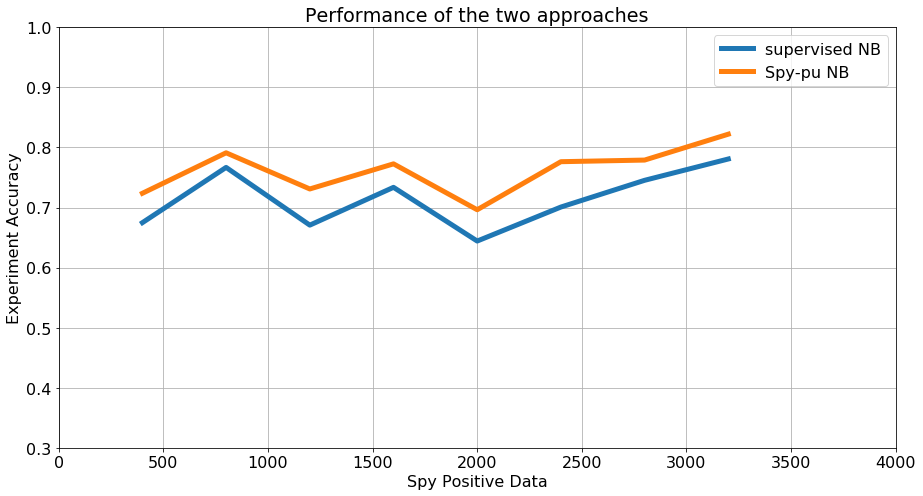

In [538]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = 15, 8
x = [400, 800, 1200, 1600,2000,2400,2800,3200]
y_std = [0.6748, 0.7668, 0.6707, 0.7336,0.6442,0.7008,0.7453,0.7808]
y_stdpu = [0.7237, 0.7911, 0.7309, 0.7727,0.6963,0.7763,0.7790,0.8221]
plt.xlim(0, 4000)
plt.ylim(0.3, 1)
plt.plot(x, y_std, marker='', mec='b', mfc='w' ,lw = 5)
plt.plot(x, y_stdpu, marker='', mec='b', mfc='w' ,lw = 5)
plt.legend([
    'supervised NB', 
    'Spy-pu NB'
])  # 让图例生效
# plt.xticks(x, names, rotation=45)
plt.margins(0)
plt.subplots_adjust(bottom=0.15)
plt.xlabel(u"Spy Positive Data") #X轴标签
plt.ylabel("Experiment Accuracy") #Y轴标签
plt.title("Performance of the two approaches") #标题
plt.savefig("classifier ")
plt.grid()
plt.show()